In [1]:
import numpy as np
import os
from datasets import LJDataset, TextMelCollate
from torch.utils.data import DataLoader
from utils import sizeof_fmt, Logger
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from model import Model, to_cuda
from IPython import display
import matplotlib.pyplot as plt
import librosa.display


In [2]:
!nvidia-smi


os.environ["CUDA_VISIBLE_DEVICES"]="1"

Thu Feb 25 12:56:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:0A:00.0 Off |                  N/A |
| 37%   61C    P0    91W / 280W |      0MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:42:00.0 Off |                  N/A |
| 60%   

In [3]:
!ls /data/datasets/LJSpeech-1.1

metadata.csv  wavs


In [4]:
trainset = LJDataset('/data/datasets/LJSpeech-1.1/')
collate_fn = TextMelCollate()

train_loader = DataLoader(trainset, num_workers=4, shuffle=True,
                          sampler=None,
                          batch_size=8, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)

print(train_loader)

In [5]:
save_dir = 'save/hvae_lj_parallel18_1'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [6]:

model = Model(in_channels=80, enc_channels=128, enc_hidden_channels=128, 
              n_blocks=1, dec_hidden_channels=128, z_channels=16, std=True)
model = model.cuda()
step = 0

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"Model size {size}")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

if False:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 99.2MiB
Model size 11.1MiB
Model size 3.4MiB
Model size 5.8MiB
0
done


In [7]:
def linear_annealing(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value
    
    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)
    return y

def linearly_growth_sawtooth_annealing(steps, num_epochs, duration):
    if steps < 0:
        return 0.0
    if steps >= duration:
        return 1.0
    
    steps_per_epoch = duration // num_epochs
    mod_steps = steps % steps_per_epoch
    epochs = steps // steps_per_epoch
    coeff = (epochs + 1) / num_epochs
    value = coeff * (1 - (np.cos(2 * np.pi * mod_steps / steps_per_epoch * 0.5) + 1) / 2)
    
    return value

def sawtooth_annealing(steps, num_epochs, duration):
    if steps < 0:
        return 0.0
    if steps >= duration:
        return 1.0
    
    steps_per_epoch = duration // num_epochs
    mod_steps = steps % steps_per_epoch
    epochs = steps // steps_per_epoch
    coeff = 1
    value = coeff * (1 - (np.cos(2 * np.pi * mod_steps / steps_per_epoch * 0.5) + 1) / 2)
    
    return value

encoding : 0.004532575607299805
alignment : 0.0004723072052001953
pooling : 0.0008502006530761719
decoding : 0.010754823684692383


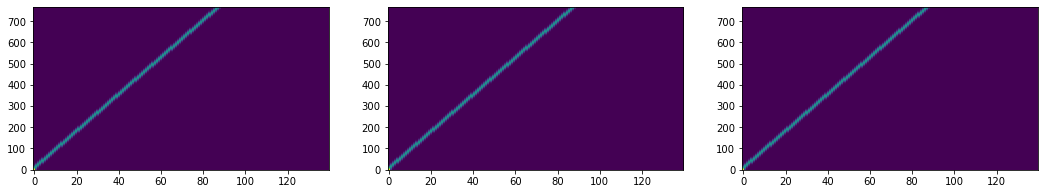

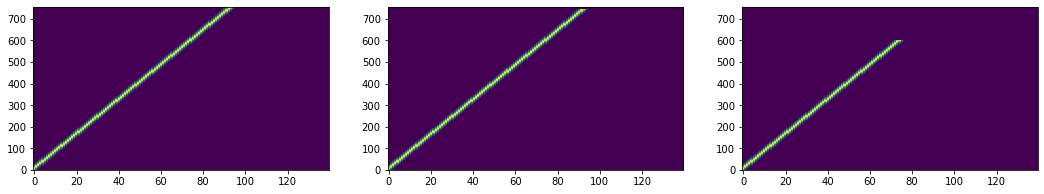

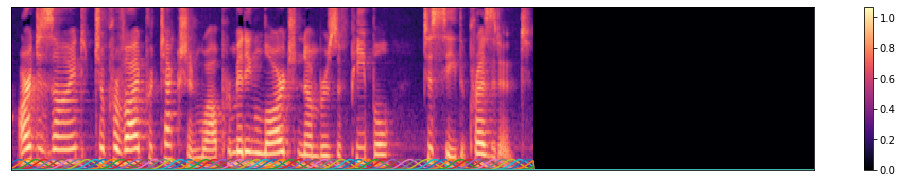

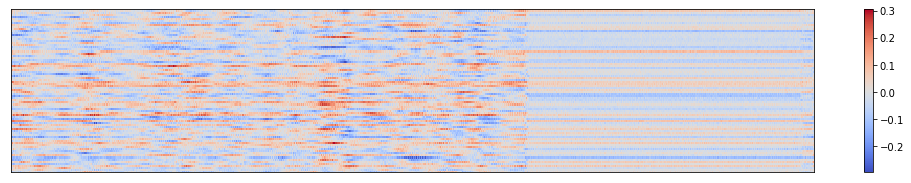

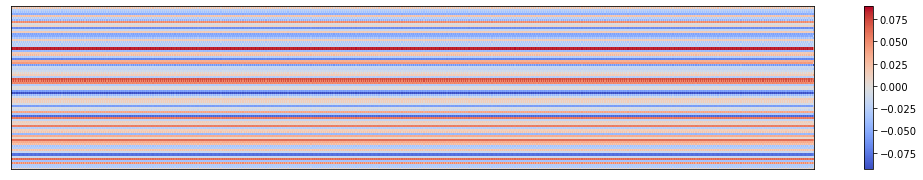

1
tensor(0.7543, device='cuda:0')
step : 1 stt : 5.4673 tts : 0.2141 recon : 0.2066 kl : 0.0014
1
tensor(0.8071, device='cuda:0')
step : 2 stt : 5.3989 tts : 0.1743 recon : 0.1671 kl : 0.0013
1
tensor(0.8350, device='cuda:0')
step : 3 stt : 5.3391 tts : 0.1923 recon : 0.1854 kl : 0.0011
1
tensor(0.8155, device='cuda:0')
step : 4 stt : 5.2746 tts : 0.2035 recon : 0.1969 kl : 0.0010
1
tensor(0.8899, device='cuda:0')
step : 5 stt : 5.1925 tts : 0.1810 recon : 0.1748 kl : 0.0008
1
tensor(0.9695, device='cuda:0')
step : 6 stt : 5.0964 tts : 0.1852 recon : 0.1793 kl : 0.0007
1
tensor(1.0652, device='cuda:0')
step : 7 stt : 4.9957 tts : 0.1844 recon : 0.1787 kl : 0.0006
1
tensor(1.1383, device='cuda:0')
step : 8 stt : 4.9059 tts : 0.1863 recon : 0.1809 kl : 0.0005
1
tensor(1.3390, device='cuda:0')
step : 9 stt : 4.7103 tts : 0.1800 recon : 0.1749 kl : 0.0004
1
tensor(1.4755, device='cuda:0')
step : 10 stt : 4.5662 tts : 0.1901 recon : 0.1853 kl : 0.0004
1
tensor(1.9579, device='cuda:0')
step 

In [ ]:

model.train()

while(True):
    
    for batch in train_loader:
        batch['mels'] = (batch['mels'] + 5) / 5
        batch = to_cuda(batch)
        
        model.train()
        model.zero_grad()
        beta = 1
        print(beta)
        stt_outputs, tts_outputs = model(batch, beta=beta)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item())
            
        if step % 10 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', beta)    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 3
            model.eval()
            with torch.no_grad():
                samples = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=0.7)

            _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
            batch_size = _tts_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
            batch_size = _stt_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 100)
                
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _y = tts_outputs['pred'].data.cpu().numpy()
            librosa.display.specshow(_y[index])
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _s = samples.data.cpu().numpy()
            librosa.display.specshow(_s[index, :, :_y.shape[2]])
            plt.colorbar()
            plt.show()
                      
        step += 1
        

In [17]:
logger.save(step, model, optimizer)

saved save/hvae_lj_parallel18/save_32924


In [18]:
from parallel_wavegan.utils import read_hdf5

stats_filename = "chk/ljspeech_parallel_wavegan.v3/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

done


In [19]:
import torch
import yaml
import sys
sys.path.append("ParallelWaveGAN")

import parallel_wavegan.models

config = 'chk/ljspeech_parallel_wavegan.v3/config.yml'
checkpoint = 'chk/ljspeech_parallel_wavegan.v3/checkpoint-3000000steps.pkl'
device = 'cuda'

with open(config) as f:
    config = yaml.load(f, Loader=yaml.Loader)

model_class = getattr(
        parallel_wavegan.models,
        config.get("generator_type", "ParallelWaveGANGenerator"))
vocoder_model = model_class(**config["generator_params"])
vocoder_model.load_state_dict(
    torch.load(checkpoint, map_location="cpu")["model"]["generator"])

vocoder_model.remove_weight_norm()
vocoder_model = vocoder_model.eval().to(device)
use_noise_input = not isinstance(
    vocoder_model, parallel_wavegan.models.MelGANGenerator)
pad_fn = torch.nn.ReplicationPad1d(
    config["generator_params"].get("aux_context_window", 0))

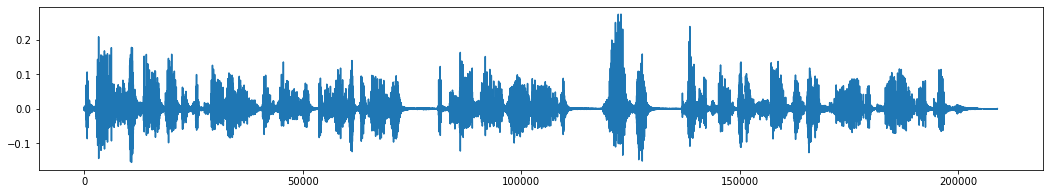

In [20]:
import matplotlib.pyplot as plt

# start generation
with torch.no_grad():
    condition = (((_s[0].T * 5) - 5) - mean) / scale
    x = ()
    if use_noise_input:
        z = torch.randn(1, 1, len(condition) * config["hop_size"]).to(device)
        x += (z,)
    condition = pad_fn(torch.from_numpy(condition).unsqueeze(0).transpose(2, 1)).to(device)
    x += (condition,)

    # generate
    y = vocoder_model(*x).view(-1).cpu().numpy()

plt.figure(figsize=[18, 3])
plt.plot(y)
plt.show()

import IPython.display as ipd
ipd.Audio(y, rate=22050)    